# Model 2: Review Baseline Example
Here, we will use all of the encoded data to create a new model using numerical features.

In [16]:
# ===============LICENSE_START=======================================================
# Apache-2.0
# ===================================================================================
# Copyright (C) 2019 AT&T Intellectual Property  All rights reserved.
# ===================================================================================
# This software file is distributed by AT&T
# under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# This file is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ===============LICENSE_END=========================================================

import pandas as pd  # data read
from sklearn import preprocessing  # data ETL
import os,sys  # file checks
import dill as pickle   # serialize functions and data as compressed binary 
import gzip  # compression 
import yaml   # configuration file
from sklearn import ensemble # classifier
from sklearn import metrics # metric plotting
from sklearn import model_selection
from matplotlib import pyplot as plt
import time

import review_utils

# for interactive graphs
# %matplotlib notebook  

config_path = 'config.yaml'
if not os.path.isfile(config_path):
    print("Sorry, can't find the configuration file {}, aborting.".format(config_path))
    sys.exit(-1)
config = yaml.safe_load(open(config_path))

In [17]:
# read our larger datasets as binary files
with gzip.open(config["path"]["etl"], 'rb') as f:
    df = pickle.load(f)
# read our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_preproc"], 'rb') as f:
    models = pickle.load(f)   
    
print(df.keys())
print("Loaded Dimensionality: Training({}), RawTest({})".format(
    df["X_train"].shape, df["X_test"].shape ))
print(df["X_train"].columns)
print(df["X_test"].columns)

df["X_train"].sample(4)


dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])
Loaded Dimensionality: Training((20299, 1115)), RawTest((5075, 6))
Index(['re_10', 're_34', 're_3m', 're_able', 're_actually', 're_address',
       're_adhesive', 're_amazon', 're_avery', 're_away',
       ...
       'cat_voip', 'cat_wall calendars', 'cat_wirebound notebooks',
       'cat_wooden colored pencils', 'cat_wrist rests',
       'cat_writing & correction supplies', 't_DOW', 't_month', 't_year',
       't_day'],
      dtype='object', length=1115)
Index(['helpful', 'reviewText', 'summary', 'unixReviewTime', 'categories',
       'description'],
      dtype='object')


,re_10,re_34,re_3m,re_able,re_actually,re_address,re_adhesive,re_amazon,re_avery,re_away,...,cat_voip,cat_wall calendars,cat_wirebound notebooks,cat_wooden colored pencils,cat_wrist rests,cat_writing & correction supplies,t_DOW,t_month,t_year,t_day
22346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.2,1.0,-0.666667
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,-1.0,0.266667
9307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,-0.8,1.0,0.000000
10089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.333333,-0.8,0.0,-0.200000


# Preprocessing 
Preprocessing will run through required steps to generate extra columns and normalize (according to inputs) for the underlying predictors to train/evaluate a sample.

In [18]:
# save the FUNCTION and a data example for later use!
df["X_test_enc"] = df["X_test"].copy()
df["X_test_enc"] = models["fn_preproc"](models, df["X_test"])

Preprocessing text column 'reviewText'...
... dimensionality after processing (5075, 305)
Preprocessing text column 'summary'...
... dimensionality after processing (5075, 604)
Preprocessing text column 'description'...
... dimensionality after processing (5075, 903)
Preprocessing vectorized 'helpful' ...
Preprocessing one-hot category columns...
... dimensionality after processing (5075, 1112)
Preprocessing vectorized 'unixReviewTime' ...
... dimensionality after processing (5075, 1116)


# Performance Evaluation
This quick function will plot the performance of our algorithm by finding the [area under the curve (aka ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

For basic models, a number of sample models from scikit are included as possibilities, like a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and or a [GradientBoostedClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier).  The model utilized is chosen by the configuration file setting `model_type`.

A more advanced model training process is also included called [cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).  Here, we use cross validalidation to explore a number of parameter settings (and random starts) to find the best performing model configutation.  This option is also controlled in the configuration file by the parameter `cross_validate` but by default it is disabled because of the expected run time.

Finally, we can use [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) (here [average_precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) as determined by the config setting `scoring`) to more easily compare the performance of different models that we build.  It should be noted that no tunings for either model was done, so it doesn't speak to the overall fitness of one type versus another.

In [19]:
# here, we test two simple classifiers and plot their performance
models = {}
time_start = time.time()

# first, choose our model according to specification
if config["training"]["model_type"].lower()=="rf":
    # use random forest as our classifier
    models["best"] = ensemble.RandomForestClassifier(n_estimators=100)
    # create some estimator parameter set
    models["param"] = {"n_estimators":(50, 100, 200), "max_depth":(2,5)}
elif config["training"]["model_type"].lower()=="gbm":
    # use gradient boosting as our classifier
    models["best"] = ensemble.GradientBoostingClassifier()
    # create some estimator parameter set
    models["param"] = {"n_estimators":(50, 100, 200), "max_features": (2,), "learning_rate":(0.1, 0.2)}
elif config["training"]["model_type"].lower()=="bayes":
    from sklearn import naive_bayes
    # use naive bayes as our classifier
    models["best"] = naive_bayes.MultinomialNB()
    # create some estimator parameter set
    models["param"] = {"alpha":(1.0, 0.7)}
# elif X:
#     from sklearn import naive_bayes
#     # use naive bayes as our classifier
#     models["best"] = naive_bayes.MultinomialNB()
#     # create some estimator parameter set
#     models["param"] = {"alpha":(1.0, 0.7)}
#     sklearn.neighbors.KNeighborsClassifier
else:
    raise Exception("Sorry, {} is an unknown model type at this time, why not create it!?".format(config["training"]["model_type"]))

    
# want to cross-validate for training well?
#   warning: this can take quite a while because of the sample count...
if config["training"]["cross_validate"]:
    models["cv"] = model_selection.GridSearchCV(models["best"], models["param"], cv=3, verbose=2, 
                          n_jobs=config["training"]["threads"], scoring=config["training"]["scoring"], 
                          refit=config["training"]["scoring"][0], return_train_score=True)
    # execute grid search
    print("Executing grid search ({})".format(clf))
    scores = models["cv"].fit(df["X_train"], df["y_train"].values.ravel())
    models["best"] = models["cv"].best_estimator_
    print(models["cv"].cv_results_)
    # print out best performance
    print(models["best"])
    for t in ["train", "test"]:
        k = "mean_{}_{}".format(t, config["training"]["scoring"][0])
        print("{}: {}".format(k, models["cv"].cv_results_[k]))
# just do normal training...
else: 
    models["best"].fit(df["X_train"], df["y_train"].values.ravel())
models["time_train"] = (time.time() - time_start)
    

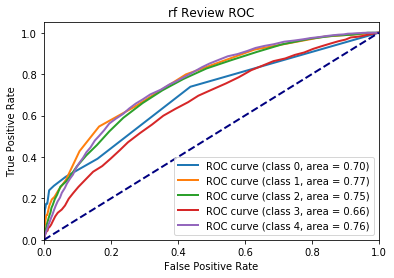

rf AUC: 0.879, trained time: 23.531s


In [20]:
# print performance!
auc_class = review_utils.draw_roc(models["best"], df["X_test_enc"], df["y_test"], "{} Review ROC".format(config["training"]["model_type"]))
print("{} AUC: {:0.3f}, trained time: {:0.3f}s".format(config["training"]["model_type"], auc_class, models["time_train"]))


In [7]:
# finally, write out our intermediate data...
# and write out our intermediate model data (in case we need to transform again)
with gzip.open(config["path"]["model_classifier"], 'wb') as f:
    pickle.dump(models, f)
